## 出租车GPS数据读取

In [0]:
import os
from dotenv import load_dotenv
import platform
import warnings
from tqdm.auto import tqdm
import numpy as np
import pickle
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import transbigdata as tbd
import datetime
import random
# import dask
# import dask.dataframe as dd
# from dask.diagnostics import ProgressBar
import math
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
# warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# sns.set_context('notebook')
# sns.set_theme(style="ticks", palette="pastel")
# plt.style.use(['grid'])

# Load environment variables from .env file
load_dotenv()
tbd.set_mapboxtoken(os.getenv('MAPBOX_TOKEN'))
# Set your map basemap storage path
# On linux or mac, the path is written like this.
# Note that there is a backslash at the end
tbd.set_imgsavepath(r'./data/')

# 设置字体
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# GPS数据
data = pd.read_csv(r'E:\taxi_data\gps_data\gps_1\20140803_train.txt', 
                         header=None,
                         names=['出租车ID', '纬度', '经度', '载客状态', '时间点'])
data['纬度']  = data['纬度'].astype(float)
data['经度']  = data['经度'].astype(float)
data['时间点'] = pd.to_datetime(data['时间点'])
data.head()

Set mapboxtoken success
Set imgsavepath success


出租车ID         纬度          经度  载客状态                 时间点
0      1  30.624806  104.136604     1 2014-08-03 21:18:46
1      1  30.624809  104.136612     1 2014-08-03 21:18:15
2      1  30.624811  104.136587     1 2014-08-03 21:20:17
3      1  30.624811  104.136596     1 2014-08-03 21:19:16
4      1  30.624811  104.136619     1 2014-08-03 21:17:44

In [1]:
# 城市数据
cd = gpd.read_file(r'data/citys.json')
cd.crs = None
cd.head()

adcode name  childrenNum     level              parent  subFeatureIndex  \
0  510104  锦江区            0  district  {'adcode': 510100}                0   
1  510105  青羊区            0  district  {'adcode': 510100}                1   
2  510106  金牛区            0  district  {'adcode': 510100}                2   
3  510107  武侯区            0  district  {'adcode': 510100}                3   
4  510108  成华区            0  district  {'adcode': 510100}                4   

                                            geometry  
0  MULTIPOLYGON (((104.05996 30.64700, 104.06392 ...  
1  MULTIPOLYGON (((104.08961 30.67009, 104.08592 ...  
2  MULTIPOLYGON (((104.13961 30.74398, 104.13721 ...  
3  MULTIPOLYGON (((103.94985 30.65859, 103.95288 ...  
4  MULTIPOLYGON (((104.08961 30.67009, 104.09472 ...

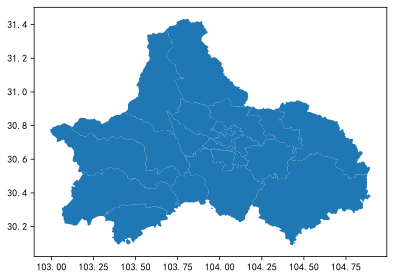

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))
cd.plot(ax=ax)
plt.show()

In [3]:
data = tbd.clean_outofshape(data, cd, col=['经度', '纬度'], accuracy=500)
data = tbd.clean_taxi_status(data, col=['出租车ID', '时间点', '载客状态'])

## 数据网格化

In [4]:
# Data gridding
bounds = [103.269638, 30.29068, 104.609693, 31.032468]
params = tbd.area_to_params(bounds, accuracy=500)
print(params)

{'slon': 103.269638, 'slat': 30.29068, 'deltalon': 0.0052274285828213946, 'deltalat': 0.004496605206422906, 'theta': 0, 'method': 'rect', 'gridsize': 500}


In [5]:
# Mapping GPS data to grids
data['LONCOL'], data['LATCOL'] = tbd.GPS_to_grid(data['经度'], data['纬度'], params)
data.head()

出租车ID        纬度          经度  载客状态                 时间点  LONCOL  LATCOL
1261      1  30.65447  104.121588     0 2014-08-03 06:00:53     163      81
1262      1  30.65447  104.121588     0 2014-08-03 06:01:53     163      81
1263      1  30.65447  104.121588     0 2014-08-03 06:02:54     163      81
1264      1  30.65447  104.121588     0 2014-08-03 06:03:54     163      81
1265      1  30.65447  104.121588     0 2014-08-03 06:04:54     163      81

In [6]:
# Aggregate data into grids
datatest = data.groupby(['LONCOL', 'LATCOL'])['出租车ID'].count().reset_index()
datatest.head()

LONCOL  LATCOL  出租车ID
0       0      61      8
1       1      61      4
2       1      62     26
3       2      43      2
4       2      62      3

In [7]:
# Generate the geometry for grids
datatest['geometry'] = tbd.grid_to_polygon([datatest['LONCOL'], datatest['LATCOL']], params)

# Change it into GeoDataFrame
datatest = gpd.GeoDataFrame(datatest)
datatest.head()

LONCOL  LATCOL  出租车ID                                           geometry
0       0      61      8  POLYGON ((103.26702 30.56272, 103.27225 30.562...
1       1      61      4  POLYGON ((103.27225 30.56272, 103.27748 30.562...
2       1      62     26  POLYGON ((103.27225 30.56722, 103.27748 30.567...
3       2      43      2  POLYGON ((103.27748 30.48179, 103.28271 30.481...
4       2      62      3  POLYGON ((103.27748 30.56722, 103.28271 30.567...

In [8]:
# Plot the grids
fig = plt.figure(1, (16, 6), dpi=300)
ax = plt.subplot(111)

tbd.plot_map(plt, bounds, style=1)
# cd.plot(ax=ax, edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0.2), linewidths=0.5)
datatest.plot(ax=ax, column='出租车ID', legend=True, scheme='quantiles')
# tbd.plotscale(ax, bounds=bounds, textsize=10, compasssize=1, accuracy=2000, rect=[0.06, 0.03], zorder=10)
plt.axis('off')
plt.title('Counting of Taxi GPS Trajectory Points', fontsize=12)

Text(0.5, 1.0, 'Counting of Taxi GPS Trajectory Points')

In [9]:
# select the records from data where the count of '出租车ID' is greater than 5378
filtered_taxi_ids = data['出租车ID'].value_counts()[data['出租车ID'].value_counts() > 5378].index
filtered_data = data[data['出租车ID'].isin(filtered_taxi_ids)]
filtered_data

出租车ID         纬度          经度  载客状态                 时间点  LONCOL  \
10730         4  30.639694  104.016481     0 2014-08-03 06:00:58     143   
10729         4  30.639689  104.016502     0 2014-08-03 06:01:56     143   
10734         4  30.639706  104.016515     0 2014-08-03 06:02:57     143   
10718         4  30.639646  104.016497     0 2014-08-03 06:03:56     143   
10717         4  30.639632  104.016502     0 2014-08-03 06:04:57     143   
...         ...        ...         ...   ...                 ...     ...   
53020202  13603  30.660038  104.094737     1 2014-08-03 23:59:10     158   
53020178  13603  30.659705  104.095432     1 2014-08-03 23:59:20     158   
53020172  13603  30.659414  104.095994     1 2014-08-03 23:59:30     158   
53020159  13603  30.659274  104.096269     1 2014-08-03 23:59:40     158   
53020160  13603  30.659282  104.096276     1 2014-08-03 23:59:50     158   

          LATCOL  
10730         78  
10729         78  
10734         78  
10718         78  
10717         78  
...          ...  
53020202      82  
53020178      82  
53020172      82  
53020159      82  
53020160      82  

[19905979 rows x 7 columns]

In [10]:
oddata = tbd.taxigps_to_od(filtered_data, col=['出租车ID', '时间点', '经度', '纬度', '载客状态'])
oddata

出租车ID               stime        slon       slat  \
10796         4 2014-08-03 07:50:33  103.993042  30.641515   
7848          4 2014-08-03 08:14:56  104.055751  30.555924   
9884          4 2014-08-03 08:41:19  104.076362  30.629396   
10192         4 2014-08-03 08:46:49  104.072707  30.633710   
10922         4 2014-08-03 08:54:40  104.062962  30.644422   
...         ...                 ...         ...        ...   
53018339  13603 2014-08-03 22:38:08  104.038714  30.638574   
53018216  13603 2014-08-03 22:41:43  104.043807  30.637575   
53019322  13603 2014-08-03 22:51:56  104.027450  30.648104   
53020142  13603 2014-08-03 23:23:18  104.076631  30.658919   
53019320  13603 2014-08-03 23:40:37  104.117263  30.648079   

                       etime        elon       elat      ID  
10796    2014-08-03 08:13:43  104.051494  30.555723       0  
7848     2014-08-03 08:35:18  104.076826  30.626624       1  
9884     2014-08-03 08:45:57  104.074862  30.633761       2  
10192    2014-08-03 08:53:35  104.062385  30.643495       3  
10922    2014-08-03 09:00:20  104.075669  30.639856       4  
...                      ...         ...        ...     ...  
53018339 2014-08-03 22:40:04  104.042143  30.636668  129081  
53018216 2014-08-03 22:49:05  104.030059  30.648555  129082  
53019322 2014-08-03 23:11:34  104.098149  30.648792  129083  
53020142 2014-08-03 23:35:17  104.116948  30.650944  129084  
53019320 2014-08-03 23:44:58  104.109106  30.657281  129085  

[129086 rows x 8 columns]

In [11]:
data_deliver, data_idle = tbd.taxigps_traj_point(filtered_data, oddata, 
                                                 col=['出租车ID', '时间点', '经度', '纬度', '载客状态'])

In [12]:
tbd.visualization_trip(data_deliver, col=['经度', '纬度', '出租车ID', '时间点'])

Processing trajectory data...
Generate visualization...
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hizm36i', 'type': …

## （到此为止）栅格化、地图

<Axes: xlabel='count', ylabel='Count'>

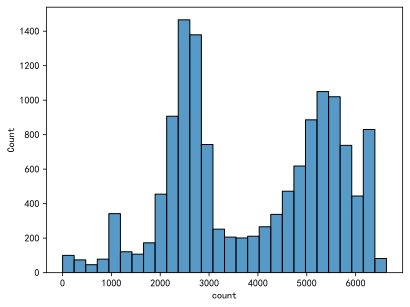

In [13]:
sns.histplot(x=data[['出租车ID']].value_counts())

In [14]:
meta = pd.DataFrame({'wid': pd.Series(dtype='object'),
                     'oid': pd.Series(dtype='object'),
                     'lon': pd.Series(dtype='float64'),
                     'lat': pd.Series(dtype='float64'),
                     'dt': pd.Series(dtype='datetime64[ns]')})

output_expanded = os.path.join(ROOT, 'expanded')
if not os.path.exists(output_expanded) or len(os.listdir(output_expanded)) == 0:
    with ProgressBar():
        ddf_origin.map_partitions(map_expand, meta=meta).to_parquet(output_expanded)

ddf_expanded = dd.read_parquet(get_filepaths(output_expanded, 'part', '.parquet'))
ddf_expanded.head()

NameError: name 'ROOT' is not defined

In [ ]:
min_lat, max_lat, min_lon, max_lon = dd.compute(
    ddf_expanded['lat'].min(),
    ddf_expanded['lat'].max(),
    ddf_expanded['lon'].min(),
    ddf_expanded['lon'].max(),
)
min_lat, max_lat, min_lon, max_lon

In [ ]:
def gps_to_grid(lat, lon):
    """ Calculate grid index for a given GPS coordinate """
    lat_index = int((lat - (min_lat - delta_lat / 2)) / delta_lat)
    lon_index = int((lon - (min_lon - delta_lon / 2)) / delta_lon)
    return lat_index, lon_index


def grid_to_gps(lat_index, lon_index):
    """ Calculate GPS coordinates of the center point for a given grid index """
    lat = lat_index * delta_lat + min_lat
    lon = lon_index * delta_lon + min_lon
    return lat, lon

In [ ]:


grid_size = 250
earth_radius = 6371004

min_lat, max_lat, min_lon, max_lon = (30.65283, 30.72649, 104.04211, 104.12907)
delta_lat = grid_size * 360 / (2 * math.pi * earth_radius)
delta_lon = grid_size * 360 / (2 * math.pi * earth_radius * math.cos((min_lat + max_lat) * math.pi / 360))
ddf_selected['lon_index'] = ((ddf_selected['lon'] - (min_lon - delta_lon / 2)) / delta_lon).astype('int')
ddf_selected['lat_index'] = ((ddf_selected['lat'] - (min_lat - delta_lat / 2)) / delta_lat).astype('int')

output_grid = os.path.join(DATASET, 'grid.shp')

# Grids
grid_data_list = []
num_lon_grids = int((max_lon - min_lon) / delta_lon) + 1
num_lat_grids = int((max_lat - min_lat) / delta_lat) + 1
for i in range(num_lon_grids):
    center_lon = i * delta_lon + min_lon
    for j in range(num_lat_grids):
        center_lat = j * delta_lat + min_lat
        grid_polygon = Polygon([
            (center_lon - delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat + delta_lat / 2),
            (center_lon - delta_lon / 2, center_lat + delta_lat / 2)
        ])
        grid_data_list.append({
            'lon_index': i,
            'lat_index': j,
            'lon_center': center_lon,
            'lat_center': center_lat,
            'geometry': grid_polygon
        })
grid_data = gpd.GeoDataFrame(grid_data_list, columns=['lon_index', 'lat_index', 'lon_center', 'lat_center', 'geometry'])
grid_data.set_geometry('geometry', inplace=True)
grid_data.to_file(output_grid)
gdf_grid = gpd.read_file(output_grid)

# Tasks
output_task = os.path.join(DATASET, 'oid_peek.csv')

if not os.path.exists(output_task):
    with ProgressBar():
        oid_peek = ddf_selected[['lon_index', 'lat_index', 'oid']].groupby(by=['lon_index', 'lat_index'])['oid'].count().reset_index().compute()
        oid_peek.sort_values(by='oid', ascending=False).to_csv(output_task, index=False)

oid_peek = pd.read_csv(output_task).sort_values('oid', ascending=False)
tasks = oid_peek[oid_peek['oid'] >= 6e4].copy()
tasks['lat_lon'] = tasks['lat_index'].astype(str) + '-' + tasks['lon_index'].astype(str)


gdf_grid_filtered = gdf_grid.merge(tasks[['lon_index', 'lat_index']],
                                   on=['lon_index', 'lat_index'],
                                   how='inner')
print(gdf_grid_filtered.shape)
fig, axes = plt.subplots(1, 2, figsize=(16, 7.5))
gdf_grid.plot(ax=axes[0], edgecolor='white', linewidth=0.2)
gdf_grid_filtered.plot(ax=axes[1], edgecolor='white', linewidth=0.2)

## 工人、任务提取

We use the Didi-Gaia GPS data as its better mobility. While we only focus on the **ID, Time and GPS records** in the experiments. Furthermore, we select **196** taxis as users because their reords are continuous and have the similar periods of time. The records collected by taxis over **24 hours** are shown in Fig. 4. Furthermore, we get the thermodynamic map and select the **PoIs** based on it. We select the most frequently access Points as the PoIs in the experiments. Here, the selected **13 PoIs** have also been outlined in red on Fig. 4.

## 计算 $P(i, j)$

## 算法实现

## 评价指标、绘图